# 9. 폐렴아 기다려라!

## 9-6. 프로젝트: 폐렴 진단기 성능 개선

---

### 목차
- Step 1. 실험환경 Set-up
- Step 2. 데이터 준비하기
- Step 3. 데이터 시각화
- Step 4. CNN 모델링
- Step 5. 데이터 imbalance 처리
- Step 6. 모델 훈련
- Step 7. 결과 확인과 시각화

- 폐렴 진단기 성능 개선 시도해보기
- 결론
- 회고

---

### Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

- 라이브러리 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

- callback 설정
    - [Callbacks API](https://keras.io/api/callbacks/)
        - You can use callbacks to:
            - Write TensorBoard logs after every batch of training to monitor your metrics
            - Periodically save your model to disk
            - Do early stopping
            - Get a view on internal states and statistics of a model during training
            - ...and more

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def get_callbacks(model_name):
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1),  # val_loss 개선이 없으면 종료
        tf.keras.callbacks.ModelCheckpoint(filepath='save_models/' + model_name + '.{epoch:02d}-{val_loss:.2f}.h5'),  # 모델 저장
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),  # 로그 저장
    ]

    return my_callbacks

- 데이터 가져오기

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '.'
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

BATCH_SIZE_2 = 32
EPOCHS_2 = 50

### Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

- 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))  # 5216 # 89%
print(len(test_filenames))  # 624 # 10.7%
print(len(val_filenames))  # 16 # 0.3%

5216
624
16


- val 개수가 너무 적음! => train 에서 val 에 쓰일 데이터 가져오기

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))  # 4185
print(len(val_filenames))  # 1047

4185
1047


- 정상, 폐렴 이미지 구분

In [5]:
print(f'Normal image path\n{filenames[0]}')  # filenames[0]: .\chest_xray\data\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
print(f'Pneumonia image path\n{filenames[2000]}')  # filenames[2000]: .\chest_xray\data\train\PNEUMONIA\person610_bacteria_2475.jpeg

Normal image path
.\chest_xray\data\train\NORMAL\NORMAL2-IM-0707-0001.jpeg
Pneumonia image path
.\chest_xray\data\train\PNEUMONIA\person610_bacteria_2475.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")  # 1072 # 정상 이미지 개수


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")  # 3113 # 폐렴 이미지 개수

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


### mini-batch 사용

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 라벨 생성 함수

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

- 제각각인 이미지의 크기를 통일시키고 줄이는 함수

In [10]:
# 이미지를 알맞은 형식(float)으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

- train 데이터셋과 validation 데이터셋 생성

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- 이미지 리사이즈 확인, 라벨 확인
    - train_ds.take(1): 데이터 1개 가져오기

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)  # (180, 180, 3)
    print("Label: ", label.numpy())  # False

Image shape:  (180, 180, 3)
Label:  False


- test 데이터셋 생성 및 데이터 개수 확인

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)  # 624

624


- tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환

In [14]:
def prepare_for_training(ds, batch_size=16, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds, BATCH_SIZE)
val_ds = prepare_for_training(val_ds, BATCH_SIZE)

### Step 3. 데이터 시각화
학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

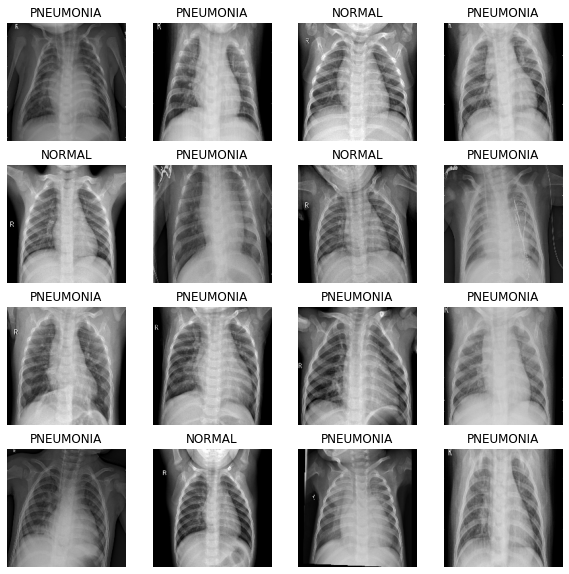

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch, batch_size=16):
    plt.figure(figsize=(10,10))
    for n in range(batch_size):
        ax = plt.subplot(4,math.ceil(batch_size/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), BATCH_SIZE)

### Step 4. CNN 모델링
의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

- Convolution Block 생성 함수

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- Dense Block 생성 함수
    - 2개의 regularization 기법: Normalization, Dropout
    - => 같이 쓰면 안 된다 vs 같이 쓰면 성능 향상에 효과가 있다

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

- 약간의 수정을 거쳐 만들어진 CNN 모델

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step 5. 데이터 imbalance 처리
실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

- Weight balancing
    - training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여
    - Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원
    - 'Normal'보다 'Pneumonia' 데이터가 많이 있었음 => imbalance함 => weight balancing 적용해서 해결 => normal 에 가중치 큰 값 부여

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # Normal
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  # Pneumonia

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))  # 1.95
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))  # 0.67

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Step 6. 모델 훈련
loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [20]:
def model_setting(device_setting='/GPU:0'):
    with tf.device(device_setting):
        model = build_model()

        METRICS = [
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
        
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',  # 이미지, 라벨 2개밖에 없어서 binary_cross entrophy loss 사용
            metrics=METRICS  # 성과 측정 매트릭스: 'accuracy', 'precision', 'recall'
        )

        return model

In [21]:
model = model_setting()

In [22]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 45, 45, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       27072     
                                                      

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 37s 109ms/step - loss: 0.4238 - accuracy: 0.7931 - precision: 0.9441 - recall: 0.7671 - val_loss: 0.6005 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 30s 115ms/step - loss: 0.2387 - accuracy: 0.9033 - precision: 0.9704 - recall: 0.8974 - val_loss: 1.0472 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 28s 109ms/step - loss: 0.2269 - accuracy: 0.9116 - precision: 0.9711 - recall: 0.9084 - val_loss: 0.7711 - val_accuracy: 0.7375 - val_precision: 0.7370 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 30s 114ms/step - loss: 0.1918 - accuracy: 0.9262 - precision: 0.9775 - recall: 0.9222 - val_loss: 0.1387 - val_accuracy: 0.9538 - val_precision: 0.9959 - val_recall: 0.9413
Epoch 5/25
261/261 [==============================] - 32s 124ms/step - loss: 0.1904 - accura

### Step 7. 결과 확인과 시각화
테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

- 결과 시각화

In [24]:
def draw_history(history):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

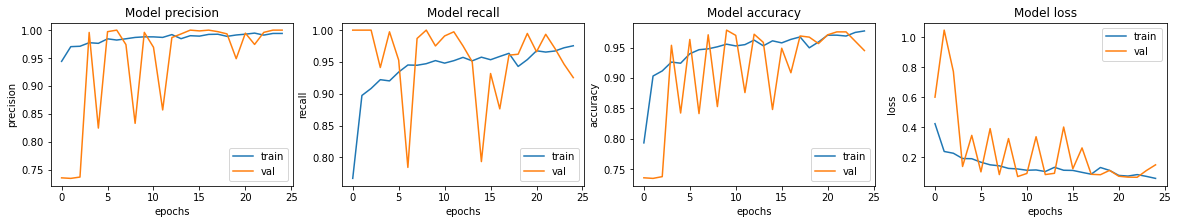

In [25]:
draw_history(history)

- 테스트 데이터로 모델 평가

In [45]:
def print_evaluation(model, test_ds):
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f'Loss: {loss:.2f},\nAccuracy: {accuracy:.2f},\nPrecision: {precision:.2f},\nRecall: {recall:.2f}')

In [27]:
print_evaluation(model, test_ds)

39/39 [==============================] - 3s 70ms/step - loss: 0.6041 - accuracy: 0.8702 - precision: 0.8472 - recall: 0.9667
Loss: 0.60,
Accuracy: 0.87,
Precision: 0.85,
Recall: 0.97


---

## 폐렴 진단기 성능 개선 시도해보기
- Data augmentation 적용하기 - tf.data API 활용
- 모델 적용해보기
    - EfficientNetB7
    - NASNetLarge

### 1) Data_augmentation 적용하기 - tf.data API 활용

In [29]:
BATCH_SIZE = 16
EPOCHS = 25

- tf.data 파이프라인을 이용하여 prepare_for_aug_training() 함수를 정의해서 데이터를 변환
    - [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers?hl=en)
        - Image preprocessing
            - tf.keras.layers.Resizing: resizes a batch of images to a target size.
            - tf.keras.layers.Rescaling: rescales and offsets the values of a batch of image (e.g. go from inputs in the [0, 255] range to inputs in the [0, 1] range.
            - tf.keras.layers.CenterCrop: returns a center crop of a batch of images.
        - Image data augmentation
            - tf.keras.layers.RandomCrop
            - tf.keras.layers.RandomFlip
            - tf.keras.layers.RandomTranslation
            - tf.keras.layers.RandomRotation
            - tf.keras.layers.RandomZoom
            - tf.keras.layers.RandomHeight
            - tf.keras.layers.RandomWidth
            - tf.keras.layers.RandomContrast
    - 전처리 레이어 적용 방법
        - 전처리 레이어를 모델의 일부로 만들기
        - 데이터 세트에 전처리 레이어 적용하기
        - => 2번째 방식 선택해서 적용
        - 참고: [Tensorflow 에서 Data augmentation - 전처리 레이어 활용](https://kjk1208.github.io/devlog/2021/06/03/tensorflow_study(2)-data-augmentation/)

In [30]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),  # 반전(뒤집기)
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.05),  # 회전
    tf.keras.layers.experimental.preprocessing.RandomZoom(-0.05, 0.05),  # 확대/축소
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.05, 0.05, fill_mode='constant'),  # 상하 이동 - 여백 픽셀값 0 으로 채움(fill_mode='constant')
])

In [31]:
def prepare_for_aug_training(ds, batch_size, shuffle_buffer_size=1000):
    ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),  # augment 함수 적용
            num_parallel_calls=AUTOTUNE
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [32]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train + validation => filenames
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# filenames 를 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 정상, 폐렴 이미지 개수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# train, validation 나누기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train, validation 이미지 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# train, validation, test 데이터셋 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()  # test 이미지 개수
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 반환
train_ds = prepare_for_aug_training(train_ds, BATCH_SIZE)  # train set 에서만 data augmentation 을 적용함!
val_ds = prepare_for_training(val_ds, BATCH_SIZE)

# 데이터 imbalance 처리를 위한 weight balancing 계산
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # Normal
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  # Pneumonia
class_weight = {0: weight_for_0, 1: weight_for_1}

- 데이터 시각화

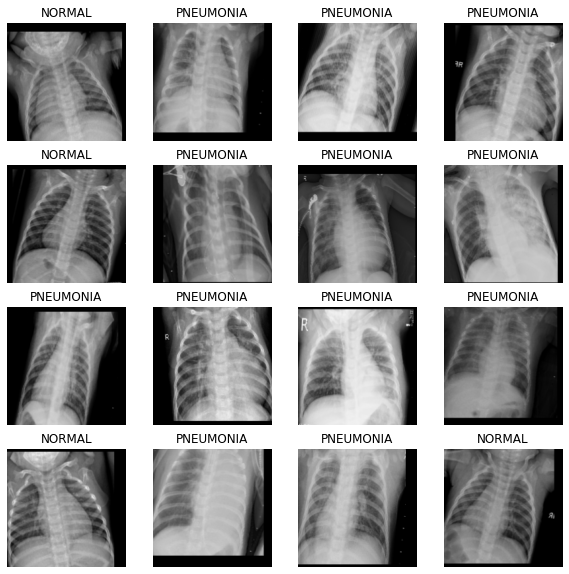

In [33]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), BATCH_SIZE)

- 데이터 imbalance 처리

In [34]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # Normal
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  # Pneumonia

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))  # 1.95
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))  # 0.67

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


- CNN 모델 생성 및 훈련

In [35]:
model_aug = model_setting()

In [36]:
model_aug.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 sequential_9 (Sequential)   (None, 45, 45, 32)        2160      
                                                                 
 sequential_10 (Sequential)  (None, 22, 22, 64)        7392      
                                                                 
 sequential_11 (Sequential)  (None, 11, 11, 128)       27072     
                                                     

In [41]:
my_callbacks = get_callbacks('model_aug')  # callbacks 설정(EarlyStopping 등)

with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks
    )

Epoch 1/25
261/261 [==============================] - 43s 145ms/step - loss: 0.3097 - accuracy: 0.8652 - precision: 0.9636 - recall: 0.8511 - val_loss: 0.7254 - val_accuracy: 0.6567 - val_precision: 1.0000 - val_recall: 0.5327
Epoch 2/25
261/261 [==============================] - 37s 141ms/step - loss: 0.2782 - accuracy: 0.8812 - precision: 0.9638 - recall: 0.8731 - val_loss: 0.1523 - val_accuracy: 0.9433 - val_precision: 0.9770 - val_recall: 0.9450
Epoch 3/25
261/261 [==============================] - 37s 143ms/step - loss: 0.2707 - accuracy: 0.8855 - precision: 0.9654 - recall: 0.8779 - val_loss: 0.1402 - val_accuracy: 0.9471 - val_precision: 0.9657 - val_recall: 0.9619
Epoch 4/25
261/261 [==============================] - 35s 135ms/step - loss: 0.2411 - accuracy: 0.8958 - precision: 0.9727 - recall: 0.8847 - val_loss: 0.9770 - val_accuracy: 0.6394 - val_precision: 1.0000 - val_recall: 0.5079
Epoch 5/25
261/261 [==============================] - 39s 149ms/step - loss: 0.2462 - accura

- 시각화

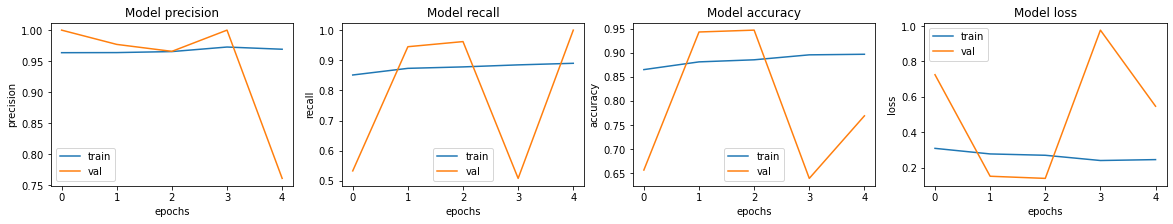

In [43]:
draw_history(history_aug)

- 모델 평가

In [46]:
print_evaluation(model_aug, test_ds)

39/39 [==============================] - 3s 76ms/step - loss: 1.3845 - accuracy: 0.6346 - precision: 0.6311 - recall: 1.0000
Loss: 1.38,
Accuracy: 0.63,
Precision: 0.63,
Recall: 1.00


### 2) 모델 적용해보기

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FEKClg%2FbtqLRVUE6hY%2FJ2kw9KKxmCaVTsqY42zrUK%2Fimg.png)

- 연산량이 적으면서 정확도가 높은 모델 선택
    - EfficientNet 모델: B0 부터 B7 까지 있다. 성능이 제일 좋은 B7 사용, batch_size 줄여야 OOM 발생을 막을 수 있음 [EfficientNet B0 to B7](https://keras.io/api/applications/efficientnet/)
    - NASNet 모델: NasNetMobile 보다 높은 정확도를 가진 NasNetLarge 모델 사용, batch_size 줄여야 OOM 발생을 막을 수 있음 [NasNetLarge and NasNetMobile](https://keras.io/api/applications/nasnet/)
    - AmoebaNet 모델은 규모가 커서 구현 및 실행하기 어려움. 구글 클라우드 코랩에서 TPU 를 사용해서 실행해 볼 수 있음 => 지금 바로 사용 불가 [모바일넷(MobileNet), 나스넷(NASNet), 아메바넷(AmoebaNet)](https://lv99.tistory.com/39) [Cloud TPU에서 AmoebaNet-D 학습](https://cloud.google.com/tpu/docs/tutorials/amoebanet)

### 2-1) EfficientNet

In [65]:
BATCH_SIZE = 4
EPOCHS = 25

In [66]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train + validation => filenames
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# filenames 를 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 정상, 폐렴 이미지 개수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# train, validation 나누기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train, validation 이미지 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# train, validation, test 데이터셋 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()  # test 이미지 개수
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 반환
train_ds = prepare_for_aug_training(train_ds, BATCH_SIZE)  # data_augmentation 적용
val_ds = prepare_for_training(val_ds, BATCH_SIZE)

# 데이터 imbalance 처리를 위한 weiht balancing 계산
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # Normal
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  # Pneumonia
class_weight = {0: weight_for_0, 1: weight_for_1}

In [67]:
efficientNetB7_model = tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(180,180,3),
    pooling='avg',
    classes=1,
)

x = tf.keras.layers.Dense(128, activation='relu')(efficientNetB7_model.output)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

efficientNetB7_model = tf.keras.Model(efficientNetB7_model.input, x)

In [68]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
efficientNetB7_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

efficientNetB7_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 180, 180, 3)  0           ['input_6[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 180, 180, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                            

In [69]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

my_callbacks = get_callbacks('efficientNetB7_model')

with tf.device('/GPU:0'):
    history_efficientNetB7 = efficientNetB7_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks  # callbacks 설정(EarlyStopping 등)
    )

Epoch 1/25
1046/1046 [==============================] - 403s 356ms/step - loss: 0.4519 - accuracy: 0.7947 - precision: 0.9312 - recall: 0.7820 - val_loss: 0.7368 - val_accuracy: 0.7347 - val_precision: 0.7342 - val_recall: 1.0000
Epoch 2/25
1046/1046 [==============================] - 371s 355ms/step - loss: 0.3039 - accuracy: 0.8719 - precision: 0.9591 - recall: 0.8648 - val_loss: 0.6861 - val_accuracy: 0.7347 - val_precision: 0.7347 - val_recall: 1.0000
Epoch 3/25
1046/1046 [==============================] - 371s 355ms/step - loss: 0.2809 - accuracy: 0.8858 - precision: 0.9638 - recall: 0.8796 - val_loss: 12.0048 - val_accuracy: 0.7337 - val_precision: 0.7335 - val_recall: 1.0000
Epoch 4/25
1046/1046 [==============================] - 370s 354ms/step - loss: 0.2162 - accuracy: 0.9233 - precision: 0.9745 - recall: 0.9210 - val_loss: 6.1759 - val_accuracy: 0.7347 - val_precision: 0.7347 - val_recall: 1.0000
Epoch 00004: early stopping


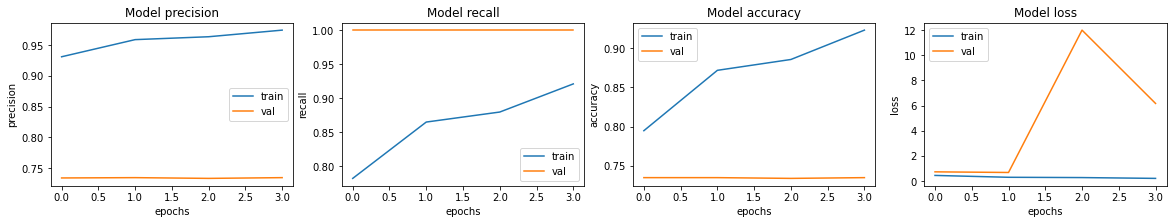

In [70]:
draw_history(history_efficientNetB7)

In [71]:
print_evaluation(efficientNetB7_model, test_ds)

156/156 [==============================] - 13s 80ms/step - loss: 8.9254 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 8.93,
Accuracy: 0.62,
Precision: 0.62,
Recall: 1.00


### 2-2) NasNet

In [72]:
BATCH_SIZE = 4
EPOCHS = 25

In [73]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

# train + validation => filenames
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# filenames 를 8:2로 나누기
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

# 정상, 폐렴 이미지 개수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

# train, validation 나누기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# train, validation 이미지 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# train, validation, test 데이터셋 생성
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()  # test 이미지 개수
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

# tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 반환
train_ds = prepare_for_aug_training(train_ds, BATCH_SIZE)  # data_augmentation 적용
val_ds = prepare_for_training(val_ds, BATCH_SIZE)

# 데이터 imbalance 처리를 위한 weight balancing 계산
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # Normal
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0  # Pneumonia
class_weight = {0: weight_for_0, 1: weight_for_1}

In [75]:
nasNetLarge_model = tf.keras.applications.NASNetLarge(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(180,180,3),
    pooling='avg',
    classes=1,
)

x = tf.keras.layers.Dense(128, activation='relu')(nasNetLarge_model.output)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

nasNetLarge_model = tf.keras.Model(nasNetLarge_model.input, x)

In [76]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
nasNetLarge_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

nasNetLarge_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 89, 89, 96)   2592        ['input_7[0][0]']                
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 89, 89, 96)   384         ['stem_conv1[0][0]']             
                                                                                                  
 activation (Activation)        (None, 89, 89, 96)   0           ['stem_bn1[0][0]']         

In [77]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

my_callbacks = get_callbacks('nasNetLarge_model')

with tf.device('/GPU:0'):
    history_nasNetLarge = nasNetLarge_model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=my_callbacks  # callbacks 설정(EarlyStopping 등)
    )

Epoch 1/25
1046/1046 [==============================] - 381s 336ms/step - loss: 0.5768 - accuracy: 0.7101 - precision: 0.9186 - recall: 0.6700 - val_loss: 8.5909 - val_accuracy: 0.5690 - val_precision: 0.9225 - val_recall: 0.4504
Epoch 2/25
1046/1046 [==============================] - 346s 331ms/step - loss: 0.3996 - accuracy: 0.8222 - precision: 0.9379 - recall: 0.8150 - val_loss: 53.8683 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
1046/1046 [==============================] - 340s 325ms/step - loss: 0.3337 - accuracy: 0.8666 - precision: 0.9532 - recall: 0.8632 - val_loss: 110.4624 - val_accuracy: 0.7328 - val_precision: 0.7328 - val_recall: 1.0000
Epoch 00003: early stopping


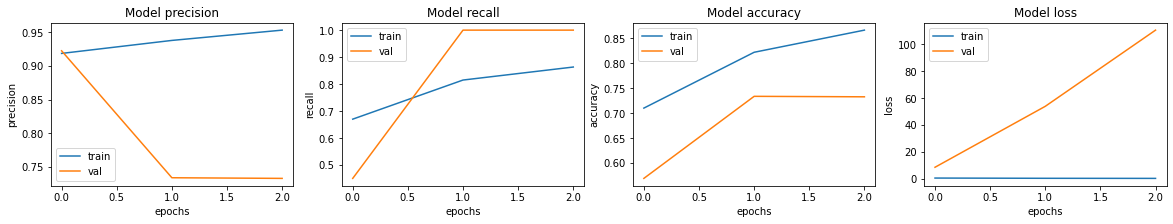

In [78]:
draw_history(history_nasNetLarge)

In [79]:
print_evaluation(nasNetLarge_model, test_ds)

156/156 [==============================] - 14s 88ms/step - loss: 175.5034 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 175.50,
Accuracy: 0.62,
Precision: 0.62,
Recall: 1.00


---

## 결론

|Evaluation|기존의 LMS 코드 CNN|data_augmentation + CNN|data_augmentation + EfficientNetB7|data_augmentation + NASNetLarge|
|:---:|:---:|:---:|:---:|:---:|
|Loss|0.6041|1.3845|8.9254|175.5034|
|Accuracy|0.8702|0.6346|0.6250|0.6250|
|Precision|0.8472|0.6311|0.6250|0.6250|
|Recall|0.9667|1.0000|1.0000|1.0000|

질병 데이터는 Accuracy 말고도 Recall 값이 중요하다. 그래서 두 지표를 우선순위로 놓고 살펴봐야 한다.

- 기존의 LMS 코드 CNN: accuracy 87%, Recall 97% 로 성능이 높게 측정되었다. 딱히 손댈 것이 없어 보인다.
- data_augmentation + CNN: accuracy 63%, Recall 100% 로 오히려 성능이 떨어진 것을 알 수 있다. tf.data API 로 변화시킨 train 데이터가 오히려 방해만 되었다. 주관적으로 쓸모 있어 보이는 함수를 골라서 사용했더니 그런 듯하다.
- data_augmentation + EfficientNetB7 모델: accuracy 63%, Recall 100% 에다가 loss 가 높다. 학습 데이터에 문제가 있는 것 같다.
- data_augmentation + NASNetLarge 모델: accuracy 63%, Recall 100% 에다가 loss 가 매우 높다. 학습이 단단히 잘못되었다. 데이터가 문제있는 것이 틀림없다.

=> data augmentation 방식이 문제가 된 것 같다. 논문을 찾아서 효과적인 data augmentation 방법을 찾아보고 적용시켜서 사용하면 해결되리라 생각한다.

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
더 좋은 방법이 뭐가 있을까 하고 찾아보다가 결국 여러 논문을 읽어봐야 된다는 것으로 결론이 나왔다. 웃긴 건 오히려 정보가 너무 많아서 갈피를 못 잡겠다는 것이었다. 기초부터 다시 복습해서 머리 속에 오버피팅시킬 필요가 있다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
1. 데이터가 부족하다면 data augmentation 기법을 사용한다. 그러나 의료 데이터일 경우 noise 때문에 오히려 방해될 수가 있으니 도입할 때 신중해야 한다.
2. train data 에서만 data augmentation 을 적용한다! [[참고: stackoverflow 질문]](https://stackoverflow.com/questions/48029542/data-augmentation-in-test-validation-set)
3. 클래스 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset' 의 인스턴스는 .take(n) 메소드로 데이터를 n개 가져올 수 있다.
4. dense block에서 2개의 regularization 기법(Normalization, Dropout)을 사용할 수도 있다! 보통 같이 쓴다면 적용 순서는 'Convolution - Batch Normalization - Activation - Dropout - Pooling' 이다. [[참고1: stackoverflow 질문]](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) [[참고2: CS231n의 Batchn Normalization 관련 강의 자료 정리]](https://gaussian37.github.io/dl-concept-order_of_regularization_term/)
5. 데이터가 imbalance 할 경우, weight balancing 으로 class_weight 를 설정하면 된다. => 데이터가 적은 클래스에 가중치를 큰 값을 부여함
6. data augmentation 을 적용 할 때, Keras 의 ImageDataGenerator 보다 Tensorflow 의 tf.data API가 더 빠르다. [[참고]](https://lynnshin.tistory.com/26) [[Tensorflow tutorials - data augmentation]](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=en)
7. [CutMix](https://hongl.tistory.com/223) = MixUp + Cutout => 이 방법을 적용하면 성능이 많이 향상된다고 함 [[참고: Image Data Augmentation Overview]](https://hoya012.github.io/blog/Image-Data-Augmentation-Overview/)
    - MixUp: 두 img 를 섞음
    - Cutout: img 의 box 를 쳐서 지움
    - 코드 구현 예시 참고 [CutMix data augmentation for image classification](https://keras.io/examples/vision/cutmix/)
8. OOM(Out Of Memory) 현상을 막는 방법으로 batch size 줄이기, 레이어 줄이기, 파라미터 줄이기, 이미지 크기 줄이기, 성능 최고인 GPU 구매하기가 있다. 주로 batch size 줄이기(e.g. batch_size=2)를 많이 사용한다.

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
>|2|데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
>|3|실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

기존의 LMS 코드로 먼저 모델을 구현해서 확인해보았다. 테스트 결과 딱히 수정이 필요할 정도인가 싶을 정도로 성능이 준수하다는 것을 알 수 있다. accuracy 87%, Recall 97% 가 나왔다. 사실상 루브릭 3번을 할 필요가 없지만 그래도 한번 시도해봤다.

기존의 LMS 코드는 regularization 으로 batch normalization 과 dropout 을 동시에 사용했다. 이 방식은 여태 사용해보지 않았기 때문에 굳이 건드리지 않고 그대로 진행했다. 둘이 같이 써서 성능 향상을 보였다는 의견이 존재하기 때문이다. tf.data API 으로 data augmentation 을 적용해보았다. 이후, 상대적으로 적은 연산량과 높은 정확도를 보이는 Keras 제공 ImageNet 모델 중에서 EfficientNetB7과 NASNetLarge 모델을 사용해보았다. 학습시간을 줄이기 위해 모두 callback 으로 early_stopping 을 사용했다. 결과는 모두 처참했다. accuracy 63%, Recall 100% 만 나온다. 좋은 모델을 썼음에도 결과가 안 좋은 것을 보면 데이터가 문제라고 결론내렸다. data augmentation 이 방해만 된 것을 알 수 있다.

오히려 실습코드에 손을 댔더니 폐기처분해야 할 정도로 성능이 하락했다. accuracy 87%, Recall 97% 에서 accuracy 63%, Recall 100% 로 괴상한 결과를 만들었다. 시간이 될 때 다른 data augmentation 기법(e.g. CutMix)을 찾아서 자유자재로 적용하는 방법을 알아봐야 겠다.

### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
애초에 기존의 LMS 코드만으로 accuracy 값이 87% 가 나왔다. 다른 방법을 시도해봤는데 오히려 안 건드리는 것이 나을 수준의 결과만 나왔다. 아마도 data augmentation 이 오히려 noise 로만 작용해서 그런 듯하다.

### - **자기 다짐**
- 관련 논문을 찾아보고 이해하는 연습을 해봐야 겠다.
- data augmentation 방법 중 CutMix 를 코드로 적용하는 방법을 알아봐야 겠다. [“CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features”, 2019](https://arxiv.org/abs/1905.04899)
- 모델에 대한 이해도가 높아졌을 때 [ImageNet winner list](https://paperswithcode.com/sota/image-classification-on-imagenet) 에서 순위권에 있는 모델들을 훑어봐야 겠다.